# Predicting the Outcome of the 2016 USA Presidential Election

## Import Libraries

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from datetime import datetime
from scipy.interpolate import make_interp_spline
import warnings
import scipy.stats as stats

sns.set_style("whitegrid")
sns.set_palette("pastel")
warnings.filterwarnings("ignore")

## Data

In [59]:
df = pd.read_csv('2016-general-election-trump-vs-clinton.csv')

In [60]:
df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Trump,Clinton,Other,Undecided,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,Insights West,2016-11-04,2016-11-07,2016-11-08T12:16:30Z,940.0,Likely Voters,Internet,41.0,45.0,2.0,8.0,http://elections.huffingtonpost.com/pollster/p...,http://www.insightswest.com/news/clinton-is-ah...,Nonpartisan,NaN,"As you may know, there will be a presidential ...",1
1,Insights West,2016-11-04,2016-11-07,2016-11-08T12:16:30Z,NaN,Likely Voters - Democrat,Internet,6.0,89.0,0.0,4.0,http://elections.huffingtonpost.com/pollster/p...,http://www.insightswest.com/news/clinton-is-ah...,Nonpartisan,NaN,"As you may know, there will be a presidential ...",1
2,Insights West,2016-11-04,2016-11-07,2016-11-08T12:16:30Z,NaN,Likely Voters - Republican,Internet,82.0,7.0,2.0,6.0,http://elections.huffingtonpost.com/pollster/p...,http://www.insightswest.com/news/clinton-is-ah...,Nonpartisan,NaN,"As you may know, there will be a presidential ...",1
3,Insights West,2016-11-04,2016-11-07,2016-11-08T12:16:30Z,NaN,Likely Voters - independent,Internet,38.0,43.0,4.0,7.0,http://elections.huffingtonpost.com/pollster/p...,http://www.insightswest.com/news/clinton-is-ah...,Nonpartisan,NaN,"As you may know, there will be a presidential ...",1
4,IBD/TIPP,2016-11-04,2016-11-07,2016-11-08T12:10:06Z,1107.0,Likely Voters,Live Phone,43.0,41.0,4.0,5.0,http://elections.huffingtonpost.com/pollster/p...,http://www.investors.com/politics/ibd-tipp-pre...,Nonpartisan,NaN,NaN,1


### Initial Observations from data

In [61]:
len(df)

1522

In [62]:
df.columns

Index(['Pollster', 'Start Date', 'End Date', 'Entry Date/Time (ET)',
       'Number of Observations', 'Population', 'Mode', 'Trump', 'Clinton',
       'Other', 'Undecided', 'Pollster URL', 'Source URL', 'Partisan',
       'Affiliation', 'Question Text', 'Question Iteration'],
      dtype='object')

In [63]:
df.isna().sum()

Pollster                     0
Start Date                   0
End Date                     0
Entry Date/Time (ET)         0
Number of Observations     509
Population                   0
Mode                         0
Trump                        0
Clinton                      0
Other                      424
Undecided                   62
Pollster URL                 0
Source URL                   0
Partisan                     0
Affiliation               1434
Question Text              861
Question Iteration           0
dtype: int64

In [64]:
df.dtypes

Pollster                   object
Start Date                 object
End Date                   object
Entry Date/Time (ET)       object
Number of Observations    float64
Population                 object
Mode                       object
Trump                     float64
Clinton                   float64
Other                     float64
Undecided                 float64
Pollster URL               object
Source URL                 object
Partisan                   object
Affiliation                object
Question Text              object
Question Iteration          int64
dtype: object

## Exclusions

### Filtering Out Rows with NaN in "Number of Observations"

In [65]:
df = df.dropna(subset=['Number of Observations'])

### Filtering Out Subgroups

In [66]:
unique_count = df['Affiliation'].nunique()

value_counts = df['Affiliation'].value_counts()

print(f"Number of unique values: {unique_count}")

print("Counts of each unique value:")
print(value_counts)


Number of unique values: 3
Counts of each unique value:
Affiliation
Dem      24
Rep      18
Other     2
Name: count, dtype: int64


In [67]:
df = df[df['Affiliation'].isna()]

In [68]:
len(df)

969

## 1: Derive and Compute the 95% Confidence Interval for $p$

In [69]:
N = 100000  # Number of voters
voter_support = np.random.choice([0, 1], size=N)

democratic_support = np.sum(voter_support)
republican_support = len(voter_support) - democratic_support

democratic_support_probability = (democratic_support / N).round(3)

standard_error = np.sqrt( (democratic_support_probability*(1-democratic_support_probability)) / N)

z_score = 1.96

result = [ float((democratic_support_probability - (z_score*standard_error)).round(3)), float((democratic_support_probability + (z_score*standard_error)).round(3))]

print(f"Number of Democratic support: {democratic_support}")
print(f"Number of Republican support: {republican_support}")
print(f"Democratic winning probability: {democratic_support_probability}")
print(f"Standard error of voter support: {standard_error}")
print(f"95 % confidence interval: {result} ")


Number of Democratic support: 50279
Number of Republican support: 49721
Democratic winning probability: 0.503
Standard error of voter support: 0.001581110369329099
95 % confidence interval: [0.5, 0.506] 


## 2: Monte Carlo Simulation for Confidence Interval

In [ ]:
def simulate_confidence_intervals(p, N, num_iterations):
    np.random.seed(42)
    z_score = 1.96
    count_capture_p = 0

    for _ in range(num_iterations):
        voters = np.random.binomial(1, p, N)

        p_hat = np.mean(voters)

        se = np.sqrt(p_hat * (1 - p_hat) / N)
        
        me = z_score * se
        
        ci_lower = p_hat - me
        ci_upper = p_hat + me

        if ci_lower <= p <= ci_upper:
            count_capture_p += 1

    capture_proportion = count_capture_p / num_iterations
    return capture_proportion

p = 0.47
N = 30
num_iterations = 100000

capture_proportion = simulate_confidence_intervals(p, N, num_iterations)
print(f"Proportion of CIs capturing the true p: {capture_proportion:.2f}")

Proportion of CIs capturing the true p: 0.93


##  3: Load and Clean the Dataset

In [71]:
df = df[['Trump', 'Clinton', 'Pollster', 'Start Date', 'Number of Observations', 'Mode']]

In [72]:
df.head()

,Trump,Clinton,Pollster,Start Date,Number of Observations,Mode
0,41.0,45.0,Insights West,2016-11-04,940.0,Internet
4,43.0,41.0,IBD/TIPP,2016-11-04,1107.0,Live Phone
5,41.0,45.0,YouGov/Economist,2016-11-04,3669.0,Internet
6,6.0,90.0,YouGov/Economist,2016-11-04,1392.0,Internet
7,84.0,4.0,YouGov/Economist,2016-11-04,1110.0,Internet


In [73]:
len(df)

969

In [74]:
df.isna().sum()

Trump                     0
Clinton                   0
Pollster                  0
Start Date                0
Number of Observations    0
Mode                      0
dtype: int64

In [75]:
df = df.dropna(subset=['Number of Observations'], ignore_index=True)

In [76]:
len(df)

969

In [77]:
df.head()

,Trump,Clinton,Pollster,Start Date,Number of Observations,Mode
0,41.0,45.0,Insights West,2016-11-04,940.0,Internet
1,43.0,41.0,IBD/TIPP,2016-11-04,1107.0,Live Phone
2,41.0,45.0,YouGov/Economist,2016-11-04,3669.0,Internet
3,6.0,90.0,YouGov/Economist,2016-11-04,1392.0,Internet
4,84.0,4.0,YouGov/Economist,2016-11-04,1110.0,Internet


In [78]:
df['Start Date'] = pd.to_datetime(df['Start Date'])
time_df = df.groupby('Start Date')[['Trump', 'Clinton']].mean().round().reset_index()
time_df

,Start Date,Trump,Clinton
0,2015-05-19,35.0,49.0
1,2015-06-20,35.0,47.0
2,2015-06-21,34.0,51.0
3,2015-06-26,35.0,59.0
4,2015-07-09,35.0,50.0
...,...,...,...
249,2016-10-31,44.0,49.0
250,2016-11-01,45.0,44.0
251,2016-11-02,41.0,45.0
252,2016-11-03,43.0,47.0


## 4. Time-Series Plot of Poll Results

In [79]:
df.isna().sum()


Trump                     0
Clinton                   0
Pollster                  0
Start Date                0
Number of Observations    0
Mode                      0
dtype: int64

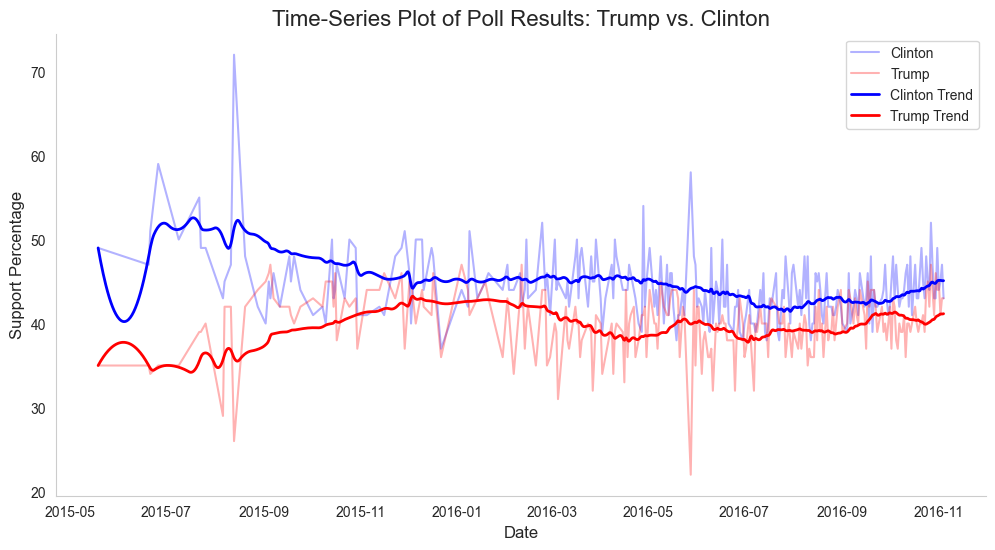

In [80]:
time_df = time_df.sort_values('Start Date')

window_size = 30 
time_df['Clinton_smooth'] = time_df['Clinton'].rolling(window=window_size, min_periods=1).mean()
time_df['Trump_smooth'] = time_df['Trump'].rolling(window=window_size, min_periods=1).mean()


plt.figure(figsize=(12, 6))

sns.lineplot(x='Start Date', y='Clinton', data=time_df, label='Clinton', ci=None, color='blue', alpha=0.3)
sns.lineplot(x='Start Date', y='Trump', data=time_df, label='Trump', ci=None, color='red', alpha=0.3)


def add_smooth_trend(x, y, color, label):
    x_numeric = pd.to_numeric(x)
    spline = make_interp_spline(x_numeric, y, k=2)

    x_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 1000)
    y_smooth = spline(x_smooth)

    plt.plot(pd.to_datetime(x_smooth), y_smooth, color=color, label=label, linewidth=2)

add_smooth_trend(time_df['Start Date'], time_df['Clinton_smooth'], color='blue', label='Clinton Trend')
add_smooth_trend(time_df['Start Date'], time_df['Trump_smooth'], color='red', label='Trump Trend')

plt.title('Time-Series Plot of Poll Results: Trump vs. Clinton', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Support Percentage', fontsize=12)
plt.legend()
plt.grid(False)
sns.despine()
plt.show()


## 5: Calculate Total Number of Voters Observed

In [81]:
Number_of_Observations = int(df['Number of Observations'].sum())
Number_of_Observations

1872688

## 6: Calculate Estimated Proportions for Trump and Clinton

In [82]:
estimated_proportion = {'Trump' : [int(df['Trump'].mean().round())],
                        'Clinton' : [int(df['Clinton'].mean().round())]}

estimated_proportion = pd.DataFrame(estimated_proportion)
estimated_proportion

,Trump,Clinton
0,40,43


## 7: Compute 95% Confidence Intervals for Trump and Clinton Support

In [83]:
trump_mean = df['Trump'].mean()
clinton_mean = df['Clinton'].mean()

trump_std = df['Trump'].std()
clinton_std = df['Clinton'].std()


trump_standard_error = ( trump_std / (math.sqrt(Number_of_Observations)))
clinton_standard_error = ( clinton_std / (math.sqrt(Number_of_Observations)))

z_score = 1.96

trump_result = [ float((trump_mean - (z_score*trump_standard_error)).round(2)) , float((trump_mean + (z_score*trump_standard_error)).round(2))]
clinton_result = [ float((clinton_mean - (z_score*clinton_standard_error)).round(2)) , float((clinton_mean + (z_score*clinton_standard_error)).round(2))]


print(f"95% confidence intervals for Trump: {trump_result}")
print(f"95% confidence intervals for Clinton: {clinton_result}")

95% confidence intervals for Trump: [40.25, 40.31]
95% confidence intervals for Clinton: [43.33, 43.4]


## 8: Hypothesis Test for Spread

In [88]:
#a
p = df['Clinton'].mean() / 100
z_score = 1.96
d = 2*p - 1
se = math.sqrt( p*(1-p)/Number_of_Observations)

CI = [ float((d - (z_score*2*se)).round(4)) , float((d + (z_score*2*se)).round(4))]

print(f"95% confidence interval for the spread d: {CI}")

#b
Z = d /  (2 * se)

p_value = 2 * (1 - stats.norm.cdf(abs(Z)))

print(f"Test Statistic (Z): {Z:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in support.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in support.")

95% confidence interval for the spread d: [-0.1341, -0.1313]
Test Statistic (Z): -183.2061
P-value: 0.0000
Reject the null hypothesis: There is a significant difference in support.
